In [1]:
import pandas as pd
import numpy as np
# # step one, dannce alignment
import os
import sys
sys.path.append(os.path.abspath('../..'))
# from utlis.sync_utlis.mini_dannce_sync import sync_videos, align_miniscope_to_sixcam


rec_path = '/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_25/20241002PMCr2_17_05'

hdf5_file_path = os.path.join(rec_path, 'MIR_Aligned/aligned_predictions_with_ca_and_dF_F.h5')

# Load the DataFrame from the HDF5 file
df_merged_with_dF_F = pd.read_hdf(hdf5_file_path, key='df')


#added the filter low variance step
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.stats import zscore

# Assuming df_merged_with_dF_F is already loaded
# Extract columns that correspond to neurons
neuron_columns = [col for col in df_merged_with_dF_F.columns if col.startswith('dF_F_roi')]
neuron_activity = df_merged_with_dF_F[neuron_columns].values  # shape: (timepoints, neurons)

# Transpose to get shape: (neurons, timepoints)
neuron_activity = neuron_activity.T

# Step to drop low-variance neurons (reduce false positives)
neuron_variances = np.var(neuron_activity, axis=1)  # Variance for each neuron
threshold = np.percentile(neuron_variances, 5)      # Keep top 95% variance
high_variance_indices = neuron_variances > threshold  # Mask for neurons to keep

# Filter neuron activity and neuron column names
neuron_activity_filtered = neuron_activity[high_variance_indices, :]
filtered_neuron_columns = [col for i, col in enumerate(neuron_columns) if high_variance_indices[i]]

# Optional: Z-score normalization along each neuron's time course
neuron_activity_normalized = zscore(neuron_activity_filtered, axis=1)
# 'correlation' is often a good metric for neural activity, but you can try 'euclidean'.
# 'average' linkage is a common choice, but feel free to experiment (e.g., 'ward', 'complete').
# Perform hierarchical clustering on the filtered and normalized data
Z = linkage(neuron_activity_normalized, method='average', metric='correlation')

# Plot the dendrogram to visualize the hierarchical structure
# plt.figure(figsize=(10, 6))
# dendrogram(Z, labels=filtered_neuron_columns, leaf_rotation=90)
# plt.title('Hierarchical Clustering Dendrogram (Filtered Neurons)')
# plt.xlabel('Neurons')
# plt.ylabel('Distance')
# plt.tight_layout()
# plt.show()

# Get the order of the leaves (neurons) from the dendrogram
neuron_order = leaves_list(Z)

# Reorder filtered and normalized neuron activity and neuron column names
neuron_activity_ordered = neuron_activity_normalized[neuron_order, :]
ordered_neuron_columns = [filtered_neuron_columns[i] for i in neuron_order]

# Plot a heatmap of the clustered neurons
# plt.figure(figsize=(12, 8))
# sns.heatmap(neuron_activity_ordered, cmap='viridis', center=0, robust=True)
# plt.title('Hierarchically Clustered Neuron Activity (Filtered & Z-scored)')
# plt.xlabel('Time')
# plt.ylabel('Neurons (clustered)')
# plt.yticks(np.arange(len(ordered_neuron_columns)) + 0.5, ordered_neuron_columns, rotation=0)
# plt.tight_layout()
# plt.show()

In [8]:

import h5py
import numpy as np
import pandas as pd

def load_filtered_data_from_h5(h5_file_path):
    """
    Loads the 'filtered_data' group from an HDF5 file into a Pandas DataFrame.
    """
    with h5py.File(h5_file_path, "r") as hf:
        # Access the group where the DataFrame columns were saved
        grp = hf["filtered_data"]
        
        # Each dataset in 'grp' is a column; read them into a dict of numpy arrays
        data_dict = {}
        for col_name in grp.keys():
            # Read dataset
            col_data = grp[col_name][:]
            
            # If it's a string dataset, h5py might already give you Python strings,
            # but just to be safe, handle bytes if encountered
            if col_data.dtype.kind in ["S", "O"] or isinstance(col_data.flatten()[0], bytes):
                col_data = [elem.decode("utf-8") if isinstance(elem, bytes) else elem 
                            for elem in col_data]
            
            data_dict[col_name] = col_data
        
    # Create a DataFrame from the data dictionary
    df = pd.DataFrame(data_dict)
    return df

import matplotlib.pyplot as plt
import numpy as np

def plot_cluster_timeline_from_df(df):
    """
    Plots a timeline of clusters per Prediction_path using 'Cluster' and 'frame' columns.
    If 'frame' doesn't exist, it falls back to 'n_frames', then finally falls back to an index.
    """
    unique_paths = df['Prediction_path'].unique()
    
    for path in unique_paths:
        # Filter data for this path
        path_data = df[df['Prediction_path'] == path]
        
        # 1) Prefer 'frame' if it exists; it's likely the actual, larger frame index.
        # 2) If not present, try 'n_frames'.
        # 3) Otherwise, fallback to a simple 0..N-1 index.
        if 'frame' in path_data.columns:
            frames = path_data['frame'].values
        elif 'n_frames' in path_data.columns:
            frames = path_data['n_frames'].values
        else:
            frames = np.arange(len(path_data))
        
        # Make sure 'Cluster' exists
        if 'Cluster' not in path_data.columns:
            print(f"Warning: 'Cluster' column not found for path '{path}', skipping.")
            continue
        clusters = path_data['Cluster'].values
        
        # Map clusters to numeric if they're not already
        if not np.issubdtype(clusters.dtype, np.number):
            unique_str_clusters = list(np.unique(clusters))
            cluster_idx_map = {val: i for i, val in enumerate(unique_str_clusters)}
            clusters_numeric = [cluster_idx_map[c] for c in clusters]
            clusters = np.array(clusters_numeric)
        
        # Create a colormap for clusters
        unique_clusters = np.unique(clusters)
        norm = plt.Normalize(vmin=min(unique_clusters), vmax=max(unique_clusters))
        cluster_colors = plt.cm.tab10(norm(clusters))
        
        # Plot
        plt.figure(figsize=(10, 2))
        scatter = plt.scatter(frames, np.zeros_like(frames), c=cluster_colors, 
                              marker='|', s=200)
        plt.title(f"Cluster Timeline for Prediction Path: {path}")
        plt.xlabel("Frames (Temporal Axis)")
        plt.yticks([])  # Hide Y-axis since it's not meaningful here

        
        # Save and show
        plt.savefig(f"{path}_cluster_timeline.png", dpi=150)
        plt.show()


def plot_cluster_timeline_from_df(df, time_index=None):
    unique_paths = df['Prediction_path'].unique()
    
    for path in unique_paths:
        path_data = df[df['Prediction_path'] == path]
        
        # Step 1: Identify frames
        if 'frame' in path_data.columns:
            frames = path_data['frame'].values
        elif 'n_frames' in path_data.columns:
            frames = path_data['n_frames'].values
        else:
            frames = np.arange(len(path_data))
        
        # Step 2: Get the clusters
        if 'Cluster' not in path_data.columns:
            print(f"Warning: 'Cluster' column not found for path '{path}', skipping.")
            continue
        clusters = path_data['Cluster'].values
        
        # If clusters are strings, map them to numeric
        if not np.issubdtype(clusters.dtype, np.number):
            unique_str_clusters = np.unique(clusters)
            cluster_idx_map = {val: i for i, val in enumerate(unique_str_clusters)}
            clusters_numeric = [cluster_idx_map[c] for c in clusters]
            clusters = np.array(clusters_numeric)
        
        # Step 3: If we have time_index, convert frames -> actual timestamps
        if time_index is not None:
            frames = frames.astype(int)
            valid_mask = (frames >= 0) & (frames < len(time_index))
            # Use the same mask for frames AND clusters <==
            frames_valid = frames[valid_mask]
            clusters_valid = clusters[valid_mask]  # <== also apply mask here
            plot_x = time_index[frames_valid]      # actual timestamps
        else:
            # If no time_index, just use frames as numeric x-axis
            frames_valid = frames
            clusters_valid = clusters
            plot_x = frames_valid
        
        # Step 4: Create colors for the valid clusters only
        unique_clusters = np.unique(clusters_valid)
        norm = plt.Normalize(vmin=min(unique_clusters), vmax=max(unique_clusters))
        
        # cluster_colors must be same length as clusters_valid
        cluster_colors_valid = plt.cm.tab10(norm(clusters_valid))  # <== also masked
        
        # Step 5: Plot
        plt.figure(figsize=(10, 2))
        plt.scatter(plot_x, np.zeros_like(plot_x), 
                    c=cluster_colors_valid,  # <== same length as plot_x
                    marker='|', s=200)
        
        plt.title(f"Cluster Timeline for Prediction Path: {path}")
        if time_index is not None:
            plt.xlabel("Time (from df_new.index)")
        else:
            plt.xlabel("Frames (Temporal Axis)")
        plt.yticks([])
        plt.tight_layout()
        
        # Save and show
        plt.savefig(f"{path}_cluster_timeline.png", dpi=150)
        plt.show()


In [5]:
aligned_dappy_path = "/home/lq53/mir_repos/dappy_24_nov/byws_version/try_results/try/aligned_mir_walalala_filtered_data.h5"
# Load it into a DataFrame
filtered_df = load_filtered_data_from_h5(aligned_dappy_path)
# print(filtered_df.head())

Columns in df_new: ['com_x', 'com_y', 'com_z', 'kp1_x', 'kp1_y', 'kp1_z', 'kp2_x', 'kp2_y', 'kp2_z', 'kp3_x', 'kp3_y', 'kp3_z', 'kp4_x', 'kp4_y', 'kp4_z', 'kp5_x', 'kp5_y', 'kp5_z', 'kp6_x', 'kp6_y', 'kp6_z', 'kp7_x', 'kp7_y', 'kp7_z', 'kp8_x', 'kp8_y', 'kp8_z', 'kp9_x', 'kp9_y', 'kp9_z', 'kp10_x', 'kp10_y', 'kp10_z', 'kp11_x', 'kp11_y', 'kp11_z', 'kp12_x', 'kp12_y', 'kp12_z', 'kp13_x', 'kp13_y', 'kp13_z', 'kp14_x', 'kp14_y', 'kp14_z', 'kp15_x', 'kp15_y', 'kp15_z', 'kp16_x', 'kp16_y', 'kp16_z', 'kp17_x', 'kp17_y', 'kp17_z', 'kp18_x', 'kp18_y', 'kp18_z', 'kp19_x', 'kp19_y', 'kp19_z', 'kp20_x', 'kp20_y', 'kp20_z', 'kp21_x', 'kp21_y', 'kp21_z', 'kp22_x', 'kp22_y', 'kp22_z', 'calcium_roi0', 'calcium_roi1', 'calcium_roi2', 'calcium_roi3', 'calcium_roi4', 'calcium_roi5', 'calcium_roi6', 'calcium_roi7', 'calcium_roi8', 'calcium_roi9', 'calcium_roi10', 'calcium_roi11', 'calcium_roi12', 'calcium_roi13', 'calcium_roi14', 'calcium_roi15', 'calcium_roi16', 'calcium_roi17', 'calcium_roi18', 'calciu

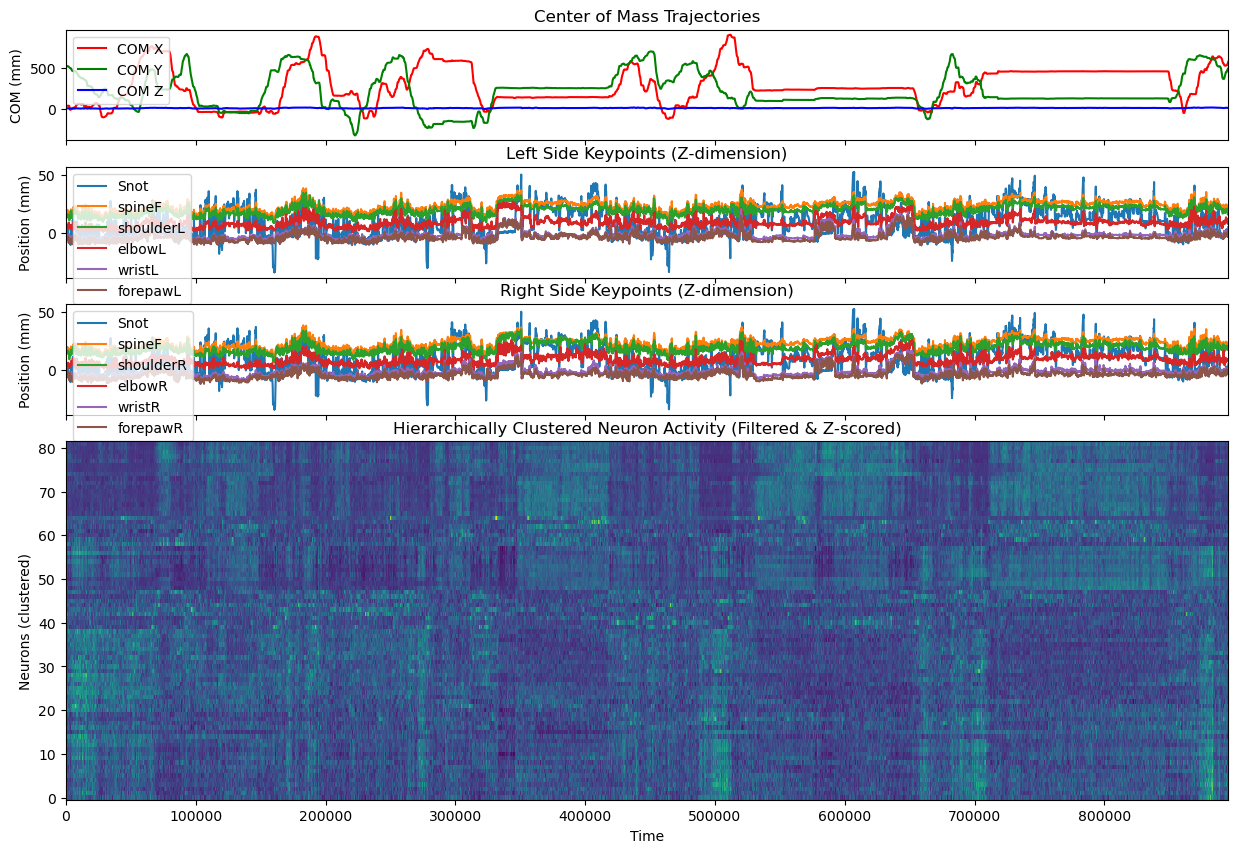

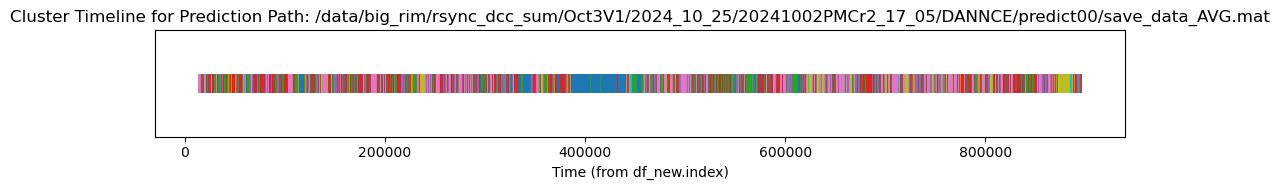

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.cluster.hierarchy import linkage, leaves_list

# %matplotlib inline  # Uncomment in Jupyter notebooks

# -------------------------------------------------------------------
# 1) Your existing code and plotting
# -------------------------------------------------------------------
df_new = df_merged_with_dF_F
# Example location indices and labels
location_indices_left = [3, 4, 12, 11, 10, 9]
location_labels_left = {3: "Snot", 4: "spineF", 12: "shoulderL", 11: "elbowL", 10: "wristL", 9: "forepawL"}

location_indices_right = [3, 4, 16, 15, 14, 13]
location_labels_right = {3: "Snot", 4: "spineF", 16: "shoulderR", 15: "elbowR", 14: "wristR", 13: "forepawR"}

time = df_new.index  # Assuming time is the index
print("Columns in df_new:", df_new.columns.tolist())  # Debug info

fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(nrows=5, ncols=1, height_ratios=[1.5, 1.5, 1.5, 1.5, 3])

###########################################
# Top Plot: COM trajectories
###########################################
ax1 = fig.add_subplot(gs[0, 0])
if 'com_x' in df_new.columns and 'com_y' in df_new.columns and 'com_z' in df_new.columns:
    ax1.plot(time, df_new['com_x'], color='red', label='COM X')
    ax1.plot(time, df_new['com_y'], color='green', label='COM Y')
    ax1.plot(time, df_new['com_z'], color='blue', label='COM Z')
    ax1.set_ylabel('COM (mm)')
    ax1.set_title('Center of Mass Trajectories')
    ax1.legend(loc='upper left')
else:
    print("COM columns not found (com_x, com_y, com_z). Check your DataFrame.")
ax1.tick_params(labelbottom=False)  # Remove x-axis labels

###########################################
# Second Plot: Left Side Keypoints (Z-dim)
###########################################
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax2.set_title('Left Side Keypoints (Z-dimension)')
for idx in location_indices_left:
    z_col = f'kp{idx}_z'
    if z_col in df_new.columns:
        ax2.plot(time, df_new[z_col], label=location_labels_left[idx])
    else:
        print(f"Warning: {z_col} not found for idx={idx}")
ax2.set_ylabel('Position (mm)')
ax2.legend(loc='upper left')
ax2.tick_params(labelbottom=False)  # Remove x-axis labels

###########################################
# Third Plot: Right Side Keypoints (Z-dim)
###########################################
ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
ax3.set_title('Right Side Keypoints (Z-dimension)')
for idx in location_indices_right:
    z_col = f'kp{idx}_z'
    if z_col in df_new.columns:
        ax3.plot(time, df_new[z_col], label=location_labels_right[idx])
    else:
        print(f"Warning: {z_col} not found for idx={idx}")
ax3.set_ylabel('Position (mm)')
ax3.legend(loc='upper left')
ax3.tick_params(labelbottom=False)  # Remove x-axis labels

###########################################
# Fourth Plot: Heatmap without Colorbar
###########################################
if 'neuron_activity_normalized' in globals() and neuron_activity_normalized is not None:
    Z = linkage(neuron_activity_normalized, method='ward')  # Hierarchical clustering
    neuron_order = leaves_list(Z)  # Get the order of the leaves
    neuron_activity_ordered = neuron_activity_normalized[neuron_order, :]
    ordered_neuron_columns = [filtered_neuron_columns[i] for i in neuron_order]

    # Time axis and neuron indices
    time_values = time  # Assuming time is the index or numpy array
    neuron_indices = np.arange(len(neuron_activity_ordered))

    # Create heatmap with pcolormesh
    ax4 = fig.add_subplot(gs[3:5, 0], sharex=ax1)  # Share x-axis
    ax4.pcolormesh(
        time_values, neuron_indices, neuron_activity_ordered,
        cmap='viridis', shading='auto'
    )

    # Heatmap labels
    ax4.set_title('Hierarchically Clustered Neuron Activity (Filtered & Z-scored)')
    ax4.set_ylabel('Neurons (clustered)')
    ax4.set_xlabel('Time')
else:
    print("Neuron activity data not found. Skipping heatmap plot.")
    ax4 = fig.add_subplot(gs[3:5, 0])
    ax4.text(0.5, 0.5, 'No neuron activity data available.',
             transform=ax4.transAxes, ha='center', va='center')


# -------------------------------------------------------------------
# 3) Example usage with filtered_df (loaded from HDF5)
# -------------------------------------------------------------------
# aligned_dappy_path = "/home/lq53/mir_repos/dappy_24_nov/byws_version/try_results/try/aligned_mir_walalala_filtered_data.h5"
# filtered_df = load_filtered_data_from_h5(aligned_dappy_path)  # You already have this function

# Now plot cluster timelines using the same time index as df_new
plot_cluster_timeline_from_df(filtered_df, time_index=df_new.index)
